In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import torch.nn as nn
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-05-14 11:50:53.613931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747223453.819670      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747223453.881307      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=c2121f872b08015222c51a0861938977e0fe620484e940cd3a0feb6e8eedb973
  Stored in directory: /root/.cache/pip/wheels/87/e5/e7/70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy


In [3]:
import idx2numpy

train_images = idx2numpy.convert_from_file("/kaggle/input/mnist-dataset/train-images.idx3-ubyte")
train_labels = idx2numpy.convert_from_file("/kaggle/input/mnist-dataset/train-labels.idx1-ubyte")

## Normalising the data:

In [4]:
train_images = train_images.astype("float32") / 255.0
train_images = (train_images - 0.5) / 0.5 

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
# Convert NumPy array to torch tensor
#_images_np = np.array(train_images)  # Shape: (N, H, W, C)
images_tensor = torch.tensor(train_images, dtype=torch.float32)
images_tensor = images_tensor.unsqueeze(1)
# Create a TensorDataset
labels_tensor = torch.tensor(train_labels, dtype=torch.long)
dataset = TensorDataset(images_tensor, labels_tensor)

# Create a DataLoader to batch and shuffle the data
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [6]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Input: (1, 28, 28)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False)  
        self.pool= nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)  
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)  
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)  
        
        self.batchnorm1 = nn.BatchNorm2d(128)
        self.batchnorm2 = nn.BatchNorm2d(256)
        
        # Final output
        self.linear = nn.Linear(256 * 3 * 3, 1)
        
    def forward(self, x):
        x = nn.functional.leaky_relu(self.conv1(x))
        
        x = nn.functional.leaky_relu(self.batchnorm1(self.conv2(x)))
        x = nn.functional.dropout(x, 0.3)
        
        x = nn.functional.leaky_relu(self.batchnorm2(self.conv3(x)))
        x = nn.functional.dropout(x, 0.3)
        
        x = nn.functional.leaky_relu(self.conv4(x))
        x = nn.functional.dropout(x, 0.3)
        
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [7]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=100, out_features=1024)
        self.batchnorm_0 = nn.BatchNorm1d(1024)
        self.linear_layer2 = nn.Linear(in_features=1024, out_features=256 * 7 * 7)
        self.batchnorm_1 = nn.BatchNorm1d(256 * 7 * 7)
        # Upsampling layers
        self.conv_trans1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True)
        self.conv_trans2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=True)
        self.conv_final = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.batchnorm1 = nn.BatchNorm2d(128)
        self.batchnorm2 = nn.BatchNorm2d(64)
        
    def forward(self, x):
        x = self.linear_layer1(x)
        x = self.batchnorm_0(x)
        x = self.linear_layer2(x)
        x = self.batchnorm_1(x)
        x = x.view(-1, 256, 7, 7)  # Reshape to (batch, 256, 7, 7)
        x = nn.functional.leaky_relu(self.batchnorm1(self.conv_trans1(x)))
        x = nn.functional.leaky_relu(self.batchnorm2(self.conv_trans2(x)))  # (64, 28, 28)
        
        x = torch.tanh(self.conv_final(x))  # (1, 28, 28)
        return x

In [8]:
class GAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gen = Generator().to(self.device)
        self.dis = Discriminator().to(self.device)

    def gen_forward(self,x):
        return self.gen.forward(x)
        
    def dis_forward(self,x):
        return self.dis.forward(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:

model=GAN()

epochs = 10
batch_size = 32
noise_dim = 100

d_optimizer = torch.optim.Adam(model.dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(model.gen.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()

for epoch in range(epochs):
    model.train()
    for i, real_images in enumerate(train_loader):
        real_images = real_images[0].to(device) if isinstance(real_images, list) else real_images.to(device)
        
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        real_output = model.dis_forward(real_images)
        d_loss_real = criterion(real_output, real_labels)
        
        noise = torch.randn(real_images.size(0), noise_dim).to(device)
        fake_images = model.gen_forward(noise)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        fake_output = model.dis_forward(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        
        output = model.dis_forward(fake_images)
        g_loss = criterion(output, real_labels) 
        g_loss.backward()
        g_optimizer.step()
        if i % 500 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] "
                f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")
    



[Epoch 0/10] [Batch 0/1875] D Loss: 1.4296 G Loss: 0.7277
[Epoch 0/10] [Batch 500/1875] D Loss: 0.8063 G Loss: 1.6337
[Epoch 0/10] [Batch 1000/1875] D Loss: 0.2622 G Loss: 3.1527
[Epoch 0/10] [Batch 1500/1875] D Loss: 0.5650 G Loss: 3.3767
[Epoch 1/10] [Batch 0/1875] D Loss: 0.3455 G Loss: 3.5117
[Epoch 1/10] [Batch 500/1875] D Loss: 0.7408 G Loss: 2.1326
[Epoch 1/10] [Batch 1000/1875] D Loss: 0.7945 G Loss: 2.8921
[Epoch 1/10] [Batch 1500/1875] D Loss: 0.5896 G Loss: 2.2093
[Epoch 2/10] [Batch 0/1875] D Loss: 0.7049 G Loss: 1.2911
[Epoch 2/10] [Batch 500/1875] D Loss: 0.2633 G Loss: 3.6238
[Epoch 2/10] [Batch 1000/1875] D Loss: 0.1023 G Loss: 4.4431
[Epoch 2/10] [Batch 1500/1875] D Loss: 0.4416 G Loss: 4.3884
[Epoch 3/10] [Batch 0/1875] D Loss: 0.9657 G Loss: 2.5164
[Epoch 3/10] [Batch 500/1875] D Loss: 0.6909 G Loss: 2.7720
[Epoch 3/10] [Batch 1000/1875] D Loss: 2.8397 G Loss: 0.4270
[Epoch 3/10] [Batch 1500/1875] D Loss: 0.2808 G Loss: 2.7319
[Epoch 4/10] [Batch 0/1875] D Loss: 0.26

In [11]:
def save_model(model):
    torch.save({
        'generator_state_dict': model.gen.state_dict(),
        'discriminator_state_dict': model.dis.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'epoch': epoch
    }, 'gan_checkpoint.pth')


In [12]:
save_model(model)

In [13]:
model_loaded = GAN()  
checkpoint = torch.load('gan_checkpoint.pth', map_location = model_loaded.device)

model_loaded.gen.load_state_dict(checkpoint['generator_state_dict'])
model_loaded.dis.load_state_dict(checkpoint['discriminator_state_dict'])

/tmp/ipykernel_31/2013149091.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('gan_checkpoint.pth', map_location = model_loaded.device)


<All keys matched successfully>

In [14]:
model_loaded.gen.eval()
model_loaded.dis.eval()

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=2304, out_features=1, bias=True)
)

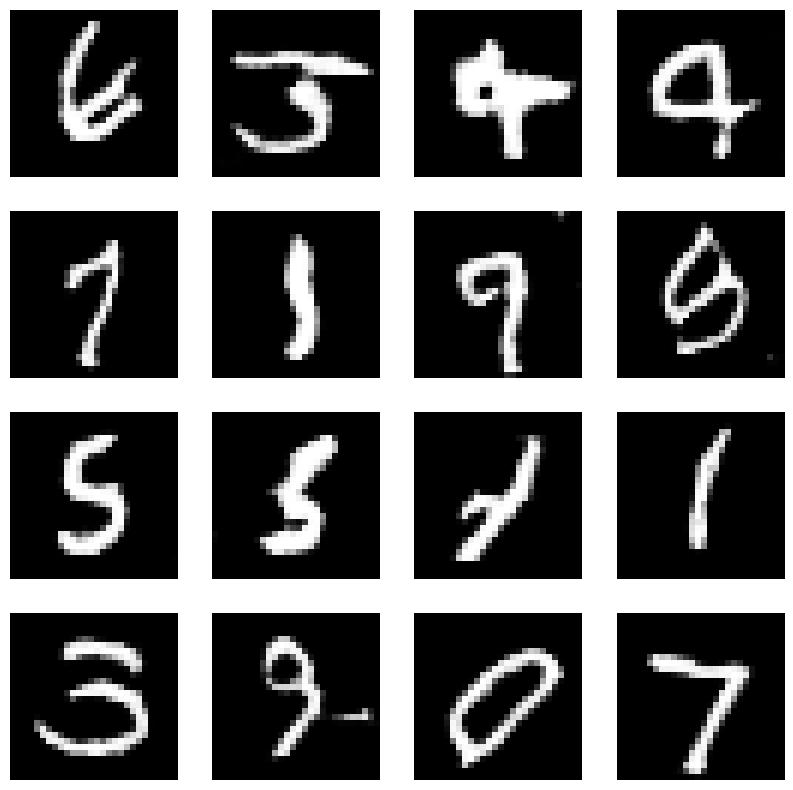

In [15]:
import matplotlib.pyplot as plt

# Generate 16 fake images
noise = torch.randn(16, noise_dim).to(device)  # Same noise_dim used in training
fake_images = model_loaded.gen(noise).detach().cpu()

# Display images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i].squeeze(), cmap="gray")  # Remove channel dim for grayscale
    ax.axis("off")
plt.show()